# Black-Scholes Delta hedging With jumps

## Theoretical Background

### Jump-Diffusion Model Overview
The Merton Jump-Diffusion model extends the classic Black-Scholes model by incorporating random jumps in asset prices, addressing key limitations of pure diffusion models:

1. **Continuous Component**: Traditional Geometric Brownian Motion
2. **Discontinuous Component**: Poisson-distributed price jumps

### Stochastic Process Representation
The asset price process is modeled as:

$$ dS_t = \mu S_t dt + \sigma S_t dW_t + S_t^- dq_t $$

Where:
- $\mu$: Drift rate
- $\sigma$: Volatility of continuous component
- $W_t$: Wiener process
- $q_t$: Poisson process representing jumps
- $S_t^-$: Asset price just before the jump

### Key Mathematical Components

#### 1. Poisson Process Characteristics
**Jump Intensity**: $\lambda$
**Jump Size Distribution**: $J \sim N(\mu_J, \sigma_J^2)$

#### 2. Compensation Term
Expected jump size: 
$$ E[e^J - 1] = \exp(\mu_J + \frac{1}{2}\sigma_J^2) - 1 $$

### Formulas in Implementation

#### Path Generation
$$ X_{t+1} = X_t + \left(r - \lambda(E[e^J] - 1) - \frac{1}{2}\sigma^2\right)dt + \sigma\sqrt{dt}Z_t + J \cdot N_t $$

Where:
- $Z_t$: Standard normal random variable
- $J$: Jump magnitude
- $N_t$: Poisson-distributed number of jumps

#### Option Pricing Modifications
Black-Scholes formula remains similar, with adjustments for jump distribution:

$$ C(S,t) = S_0 \Phi(d_1) - Ke^{-r(T-t)}\Phi(d_2) $$

#### Delta Hedging
The delta calculation incorporates jump risk:

$$ \Delta = \Phi(d_1) $$

## Simulation Methodology
- Generate multiple stock price paths with jumps
- Calculate option prices and deltas
- Dynamic hedging to manage portfolio risk
- Analyze profit and loss distribution

### Simulation Parameters
- Paths: 1000
- Time Steps: 5000
- Jump Intensity: 1
- Jump Mean: 0
- Jump Volatility: 0.30

## Mathematical Insights
1. Jumps capture fat-tail risk
2. Allows for more realistic price movements
3. Provides better model for volatile markets

## Comparative Analysis
- **Geometric Brownian Motion**: Continuous, smooth paths
- **Merton Model**: Allows sudden, significant price changes

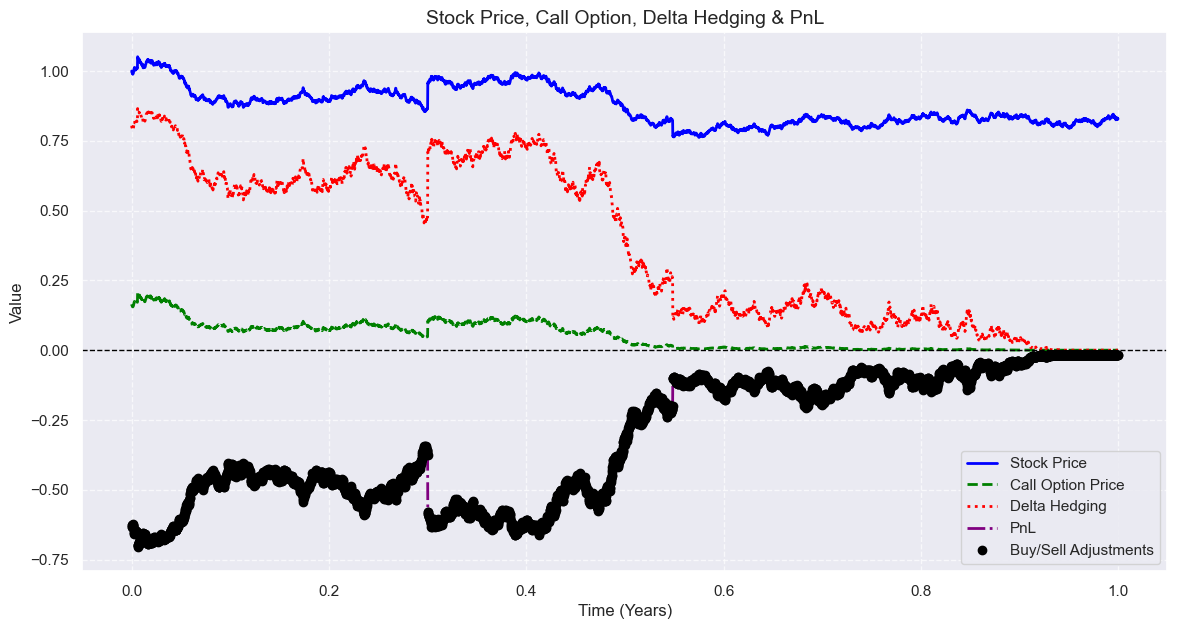

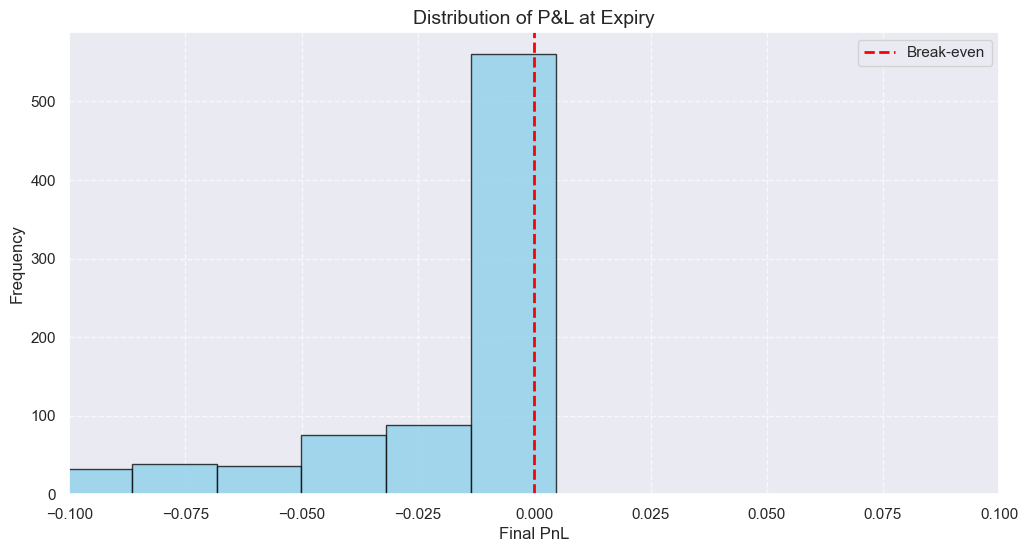

path no 10, S0=1.0, PnL(Tm-1)=-0.810864159053758, S(tm)=0.9527356627801998, max(S(Tm)-K,0)=[0.00273566],           PnL(Tm)=-0.0005557113671674774


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import enum

import seaborn as sns


# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0


def GeneratePathsMerton(NoOfPaths, NoOfSteps, S0, T, xiP, muJ, sigmaJ, r, sigma):
    # Create empty matrices for Poisson process and for compensated Poisson process
    X = np.zeros([NoOfPaths, NoOfSteps + 1])
    S = np.zeros([NoOfPaths, NoOfSteps + 1])
    time = np.zeros([NoOfSteps + 1])

    dt = T / float(NoOfSteps)
    X[:, 0] = np.log(S0)
    S[:, 0] = S0

    # Expectation E(e^J) for J~N(muJ,sigmaJ^2)
    EeJ = np.exp(muJ + 0.5 * sigmaJ * sigmaJ)
    ZPois = np.random.poisson(xiP * dt, [NoOfPaths, NoOfSteps])
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    J = np.random.normal(muJ, sigmaJ, [NoOfPaths, NoOfSteps])
    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        # making sure that samples from normal have mean 0 and variance 1
        X[:, i + 1] = X[:, i] + (r - xiP * (EeJ - 1) - 0.5 * sigma * sigma) * dt + sigma * np.sqrt(dt) * Z[:, i] \
                      + J[:, i] * ZPois[:, i]
        time[i + 1] = time[i] + dt

    S = np.exp(X)
    paths = {"time": time, "X": X, "S": S}
    return paths


def GeneratePathsGBM(NoOfPaths, NoOfSteps, T, r, sigma, S_0):
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    X = np.zeros([NoOfPaths, NoOfSteps + 1])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])
    time = np.zeros([NoOfSteps + 1])

    X[:, 0] = np.log(S_0)

    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        W[:, i + 1] = W[:, i] + np.power(dt, 0.5) * Z[:, i]
        X[:, i + 1] = X[:, i] + (r - 0.5 * sigma * sigma) * dt + sigma * (W[:, i + 1] - W[:, i])
        time[i + 1] = time[i] + dt

    # Compute exponent of ABM
    S = np.exp(X)
    paths = {"time": time, "S": S}
    return paths


# Black-Scholes Call option price
def BS_Call_Put_Option_Price(CP, S_0, K, sigma, t, T, r):
    K = np.array(K).reshape([len(K), 1])
    d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma, 2.0))
          * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    if CP == OptionType.CALL:
        value = stats.norm.cdf(d1) * S_0 - stats.norm.cdf(d2) * K * np.exp(-r * (T - t))
    elif CP == OptionType.PUT:
        value = stats.norm.cdf(-d2) * K * np.exp(-r * (T - t)) - stats.norm.cdf(-d1) * S_0
    return value


def BS_Delta(CP, S_0, K, sigma, t, T, r):
    # when defining a time-grid it may happen that the last grid point
    # is slightly after the maturity
    if t - T > 10e-20 and T - t < 10e-7:
        t = T
    K = np.array(K).reshape([len(K), 1])
    d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma, 2.0)) * \
          (T - t)) / (sigma * np.sqrt(T - t))
    if CP == OptionType.CALL:
        value = stats.norm.cdf(d1)
    elif CP == OptionType.PUT:
        value = stats.norm.cdf(d1) - 1.0
    return value


def enhanced_plotting(time, S, CallM, DeltaM, PnL, path_id=13):
    sns.set(style="darkgrid")

    # Figure 1: Stock, Call Price, Delta, PnL
    plt.figure(figsize=(14, 7))
    plt.plot(time, S[path_id, :], label="Stock Price", color="blue", linewidth=2)
    plt.plot(time, CallM[path_id, :], label="Call Option Price", color="green", linestyle="dashed", linewidth=2)
    plt.plot(time, DeltaM[path_id, :], label="Delta Hedging", color="red", linestyle="dotted", linewidth=2)
    plt.plot(time, PnL[path_id, :], label="PnL", color="purple", linestyle="dashdot", linewidth=2)

    # Mark key buy/sell decisions (example logic)
    buy_sell_points = [i for i in range(1, len(time)) if DeltaM[path_id, i] != DeltaM[path_id, i - 1]]
    plt.scatter([time[i] for i in buy_sell_points], [PnL[path_id, i] for i in buy_sell_points],
                color='black', marker='o', label="Buy/Sell Adjustments", zorder=3)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Zero Profit Line
    plt.xlabel("Time (Years)", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.title("Stock Price, Call Option, Delta Hedging & PnL", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Figure 2: Histogram of P&L
    plt.figure(figsize=(12, 6))
    plt.hist(PnL[:, -1], bins=50, color="skyblue", edgecolor="black", alpha=0.75)
    plt.axvline(0, color='red', linestyle='dashed', linewidth=2, label="Break-even")
    plt.xlim([-0.1, 0.1])
    plt.xlabel("Final PnL", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Distribution of P&L at Expiry", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


def mainCalculation():
    NoOfPaths = 1000
    NoOfSteps = 5000
    T = 1.0
    r = 0.1
    sigma = 0.2
    xiP = 1
    muJ = 0.0
    sigmaJ = 0.30
    s0 = 1.0
    K = [0.95]
    CP = OptionType.CALL

    np.random.seed(7)
    Paths = GeneratePathsMerton(NoOfPaths, NoOfSteps, s0, T, xiP, muJ, sigmaJ, r, sigma)
    time = Paths["time"]
    S = Paths["S"]

    # Setting up some handy lambdas
    C = lambda t, K, S0: BS_Call_Put_Option_Price(CP, S0, K, sigma, t, T, r)
    Delta = lambda t, K, S0: BS_Delta(CP, S0, K, sigma, t, T, r)

    # Setting up initial portfolio
    PnL = np.zeros([NoOfPaths, NoOfSteps + 1])
    delta_init = Delta(0.0, K, s0)
    PnL[:, 0] = C(0.0, K, s0) - delta_init * s0

    CallM = np.zeros([NoOfPaths, NoOfSteps + 1])
    CallM[:, 0] = C(0.0, K, s0)
    DeltaM = np.zeros([NoOfPaths, NoOfSteps + 1])
    DeltaM[:, 0] = Delta(0, K, s0)

    for i in range(1, NoOfSteps + 1):
        dt = time[i] - time[i - 1]
        delta_old = Delta(time[i - 1], K, S[:, i - 1])
        delta_curr = Delta(time[i], K, S[:, i])

        PnL[:, i] = PnL[:, i - 1] * np.exp(r * dt) - (delta_curr - delta_old) * S[:, i]  # PnL
        CallM[:, i] = C(time[i], K, S[:, i])
        DeltaM[:, i] = Delta(time[i], K, S[:, i])

    # Final transaction, payment of the option (if in the money) and selling the hedge
    PnL[:, -1] = PnL[:, -1] - np.maximum(S[:, -1] - K, 0) + DeltaM[:, -1] * S[:, -1]

    # We plot only one path at the time
    path_id = 10

    enhanced_plotting(time, S, CallM, DeltaM, PnL)

    # Table result for a given path
    print("path no {0}, S0={1}, PnL(Tm-1)={2}, S(tm)={3}, max(S(Tm)-K,0)={4}, \
          PnL(Tm)={5}".format(path_id, s0, PnL[path_id, -2], S[path_id, -1], np.maximum(S[path_id, -1] - K, 0.0),
                              PnL[path_id, -1]))


mainCalculation()
